In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Input, Dropout,GRU
from keras.optimizers import Adam 
from keras.callbacks import EarlyStopping
from scipy.integrate import odeint 
from math import *
import time

2024-10-27 19:37:43.608135: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-27 19:37:43.617813: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-27 19:37:43.629501: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-27 19:37:43.632940: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-27 19:37:43.641290: I tensorflow/core/platform/cpu_feature_guar

In [2]:
#xy0 is [x0,y0] vxy0 is [vx0, vy0]
def projectile_motion(g, mu, xy0, vxy0, tt):
    # use a four-dimensional vector function vec = [x, y, vx, vy]
    def dif(vec, t):
        # time derivative of the whole vector vec
        v = sqrt(vec[2] ** 2 + vec[3] ** 2)
        return [vec[2], vec[3], -mu * v * vec[2], -g - mu * v * vec[3]]

    # solve the differential equation numerically
    vec = odeint(dif, [xy0[0], xy0[1], vxy0[0], vxy0[1]], tt)
    return vec[:, 0], vec[:, 1], vec[:, 2], vec[:, 3]  # return x, y, vx, vy

def makepath(angle, vel, t_final,d_t):
    alpha0 = radians(angle)
    xy = [0.0, 0.0]
    vxy =[vel * cos(alpha0), vel* sin(alpha0)]
    t = np.arange(0, t_final,  d_t)
    x, y, vx, vy = projectile_motion(g, mu, (xy[0], xy[1]), (vxy[0], vxy[1]), t)
    return x, y, vx, vy, t

# Parameters of projectile (modelled after a baseball)
g       = 9.81         # Acceleration due to gravity (m/s^2)
rho_air = 1.29         # Air density (kg/m^3)
v0      = 44.7         # Initial velocity (m/s)
m       = 0.145        # Mass of projectile (kg)
cD      = 0.5          # Drag coefficient (spherical projectile)
r       = 0.0366       # Radius of projectile (m)
mu = 0.5 * cD * (pi * r ** 2) * rho_air / m

In [3]:
train_window = 15

def create_inout_sequences_batches(input_data, tw):
    inout_seq = []
    batches,L,dim = (input_data).shape
    for i in range(batches):
        for j in range(L-tw):
            train_seq = input_data[i,j:j+tw,:]
            train_label = input_data[i,j+tw:j+tw+1,:]
            inout_seq.append((train_seq ,train_label))
    return inout_seq


In [ ]:
angulos = np.arange(15,85,5)
print(angulos)

In [27]:
np.random.seed(42)
solucoes = []
angulos = np.arange(10,90,5)
velocidades = np.arange(10,500,10)
for angulo in angulos:
    for velocidade in velocidades:
        X, Y, VX, VY, T  = makepath(angulo, velocidade, 10.1, 0.1) 
        solucao = np.stack((X, Y, np.sqrt(VX**2 ,VY**2)),axis=1)
        solucoes.append(solucao)

solucoes = np.array(solucoes)

solucoes = []
for i in range(100):
    angulo = np.random.uniform(7,89)
    velocidade = np.random.uniform(50,1100)
    X, Y, VX, VY, T = makepath(angulo, velocidade,10.1,0.1) 
    solucao = np.stack((X, Y, np.sqrt(VX**2 ,VY**2)),axis=1)
    solucoes.append(solucao)

'''#Linear scaling  (x-x_min)/(x_max-m_min) (-1,1)
inputs_min = np.min(solucoes,axis=(0,1))
inputs_max = np.max(solucoes,axis=(0,1))
print(inputs_min)
print(inputs_max)
inputs_normalizados = (((solucoes-inputs_min)/(inputs_max-inputs_min))-0.5)*2'''

#Scalling manual Z score (x - x_mean)/(x_std)
inputs_mean = np.mean(solucoes,axis=(0,1))
inputs_std = np.std(solucoes,axis=(0,1))

print(inputs_mean)
print(inputs_std)

inputs_normalizados = (solucoes-inputs_mean)/(inputs_std)

solucoes2 = []
for i in range(15):
    angulo = np.random.uniform(7,89)
    velocidade = np.random.uniform(50,1100)
    X, Y, VX, VY, T = makepath(angulo, velocidade,10.1,0.1) 
    solucao = np.stack((X, Y, np.sqrt(VX**2 ,VY**2)),axis=1)
    solucoes2.append(solucao)

solucoes2 = np.array(solucoes2)
#inputs_normalizados2 = (((solucoes2-inputs_min)/(inputs_max-inputs_min))-0.5)*2
inputs_normalizados2 = (solucoes2-inputs_mean)/(inputs_std)

sequencias = create_inout_sequences_batches(inputs_normalizados,train_window) 
sequencias_val = create_inout_sequences_batches(inputs_normalizados2,train_window) 
train_inputs = tf.convert_to_tensor([sequencias[i][0] for i in range(len(sequencias))],dtype=tf.float32)
train_outputs = tf.reshape(tf.convert_to_tensor([sequencias[i][1] for i in range(len(sequencias))],dtype=tf.float32),(-1,3))
val_inputs = tf.convert_to_tensor([sequencias_val[i][0] for i in range(len(sequencias_val))],dtype=tf.float32)
val_outputs = tf.reshape(tf.convert_to_tensor([sequencias_val[i][1] for i in range(len(sequencias_val))],dtype=tf.float32),(-1,3))

[196.88049586 123.7315404   27.38086972]
[122.1374394  115.7021621   58.11669291]


In [5]:
solucoes.shape

(784, 101, 3)

In [6]:
angulos, velocidades

(array([10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85]),
 array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
        140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260,
        270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390,
        400, 410, 420, 430, 440, 450, 460, 470, 480, 490]))

In [52]:
model_keras = Sequential([
    Input((train_window,3)),
    LSTM(512, return_sequences=1),
    LSTM(256, return_sequences=0),
    (Dense(3))])
model_keras.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 15, 512)        │     1,056,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 256)            │       787,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,844,995 (7.04 MB)

 Trainable params: 1,844,995 (7.04 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
print(train_inputs.shape)

In [64]:
early_stop = EarlyStopping(monitor="val_loss",patience=150,restore_best_weights=True)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps=100,
    decay_rate=0.98)

def scaled_mse(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred) * 100)

def max_error_loss(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))+2*tf.reduce_mean(tf.abs(y_true - y_pred))



model_keras.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=0.00001,amsgrad=1), loss="mse",metrics=["mae"])
history = model_keras.fit(train_inputs,train_outputs,validation_data=(val_inputs,val_outputs),epochs=1000,batch_size=256*4, verbose = 2,callbacks=early_stop,shuffle=1)
#model_keras.save("LSTM_bal_geral.keras")

Epoch 1/1000
9/9 - 1s - 140ms/step - loss: 2.0114e-05 - mae: 0.0029 - val_loss: 8.8107e-06 - val_mae: 0.0021
Epoch 2/1000
9/9 - 0s - 30ms/step - loss: 1.1759e-05 - mae: 0.0023 - val_loss: 8.6216e-06 - val_mae: 0.0020
Epoch 3/1000
9/9 - 0s - 22ms/step - loss: 9.1508e-06 - mae: 0.0020 - val_loss: 8.5566e-06 - val_mae: 0.0020
Epoch 4/1000
9/9 - 0s - 22ms/step - loss: 8.3511e-06 - mae: 0.0019 - val_loss: 8.8858e-06 - val_mae: 0.0020
Epoch 5/1000
9/9 - 0s - 21ms/step - loss: 7.9638e-06 - mae: 0.0019 - val_loss: 9.0699e-06 - val_mae: 0.0020
Epoch 6/1000
9/9 - 0s - 22ms/step - loss: 7.6691e-06 - mae: 0.0018 - val_loss: 8.8498e-06 - val_mae: 0.0020
Epoch 7/1000
9/9 - 0s - 21ms/step - loss: 7.5627e-06 - mae: 0.0018 - val_loss: 8.7125e-06 - val_mae: 0.0020
Epoch 8/1000
9/9 - 0s - 22ms/step - loss: 7.5461e-06 - mae: 0.0018 - val_loss: 8.5853e-06 - val_mae: 0.0020
Epoch 9/1000
9/9 - 0s - 21ms/step - loss: 7.5511e-06 - mae: 0.0018 - val_loss: 8.5342e-06 - val_mae: 0.0020
Epoch 10/1000
9/9 - 0s - 22

KeyboardInterrupt: 

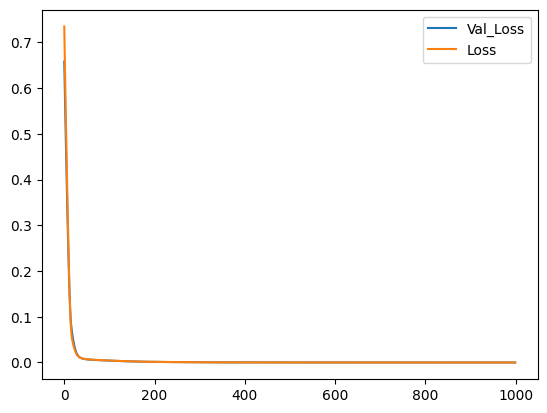

In [65]:
plt.plot(history.history["val_loss"],label="Val_Loss")
plt.plot(history.history["loss"], label="Loss")
plt.legend()
plt.show()

In [185]:
model_keras = tf.keras.models.load_model("modelos_de_verdade/LSTM_bal_geral.keras")

In [ ]:
1/0.01

In [171]:
t_pontos = np.arange(0,5+0.1,0.01)
print(t_pontos.shape)

(510,)


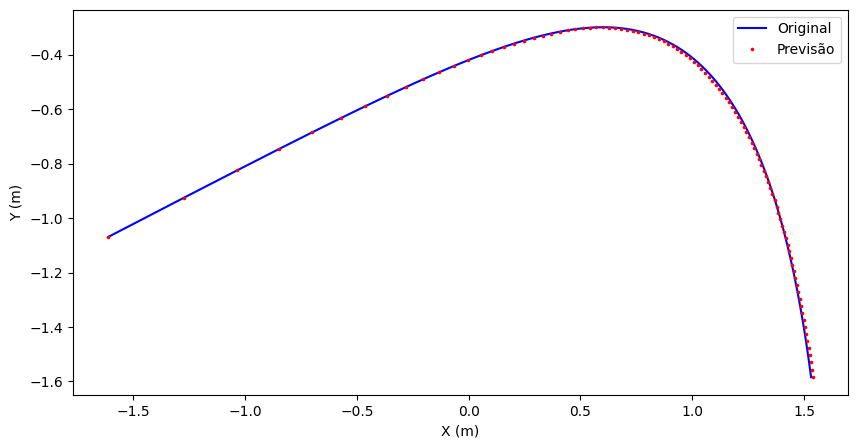

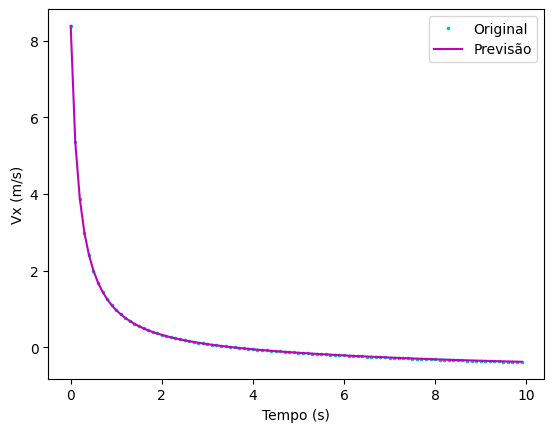

'\nplt.plot(t_pontos[m:n], v_y[m:n], \'co\', label="Original",markersize=1.6)\nplt.plot(t_pontos[m:n], vy_2[m:n], \'m-\', label="Previsão",markersize=0.4)\nplt.legend()\nplt.xlabel("Tempo (s)")\nplt.ylabel("Vy (m/s)")\nplt.show()'

In [66]:
t_final = 10
#sol2 = np.stack(makepath(85,300,t_final+0.1,0.1)[:4],axis=1)

X, Y, VX, VY, T  = makepath(22, 555, 10.1, 0.1) 
sol2 = np.stack((X, Y, np.sqrt(VX**2 ,VY**2)),axis=1)
previsoes = ((sol2[:train_window,:]+0*np.random.normal(size=(train_window,3))-inputs_mean)/inputs_std).tolist()
sol2 = (sol2-inputs_mean)/inputs_std
previsoes = (sol2[:train_window,:]+0*np.random.normal(size=(train_window,3))).tolist()
for i in range(101-train_window+t_final*10-100):
    prev_temp = model_keras((np.array([previsoes[k][:] for k in range(i,train_window+i)]).reshape(-1,train_window,3)),training=False)
    previsoes.append(prev_temp.numpy().tolist()[0])
previsoes = np.array(previsoes)

plt.figure(figsize=(10,5))
x = sol2[:,0]
y =  sol2[:,1]
v_x = sol2[:,2]
#v_y =  sol2[:,3]
x_2 = previsoes[:,0]
y_2 = previsoes[:,1]
vx_2 = previsoes[:,2]
#vy_2 = previsoes[:,3]

n = -1
m = 0

t_pontos = np.arange(0,t_final+0.1,0.1)
plt.plot(x[m:n], y[m:n], 'b-', label="Original")
plt.plot(x_2[m:n], y_2[m:n], 'ro', label="Previsão",markersize=1.6)
plt.legend()
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.show()

plt.plot(t_pontos[m:n], v_x[m:n], 'co', label="Original",markersize=1.6)
plt.plot(t_pontos[m:n], vx_2[m:n], 'm-', label="Previsão",markersize=0.4)
plt.legend()
plt.xlabel("Tempo (s)")
plt.ylabel("Vx (m/s)")
plt.show()
'''
plt.plot(t_pontos[m:n], v_y[m:n], 'co', label="Original",markersize=1.6)
plt.plot(t_pontos[m:n], vy_2[m:n], 'm-', label="Previsão",markersize=0.4)
plt.legend()
plt.xlabel("Tempo (s)")
plt.ylabel("Vy (m/s)")
plt.show()'''

In [15]:
model_keras.evaluate(train_inputs,train_outputs,batch_size=1)

26010/26010 ━━━━━━━━━━━━━━━━━━━━ 23s 865us/step - loss: 3.9516e-07 - mae: 4.6182e-04


[3.854149781545857e-07, 0.00046231981832534075]

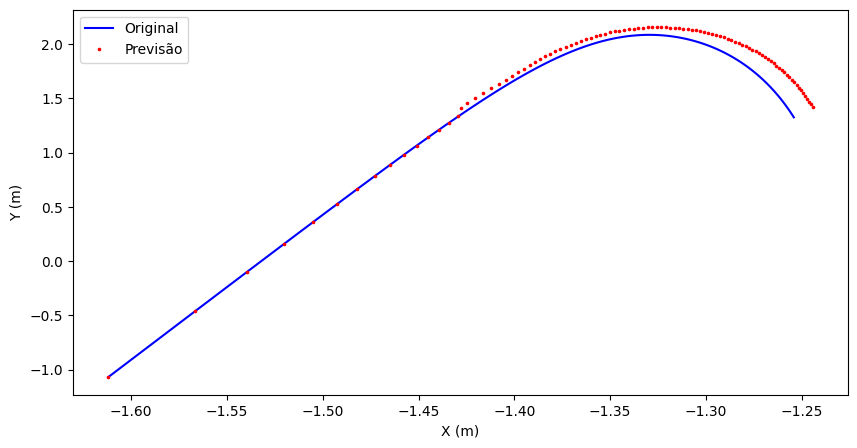

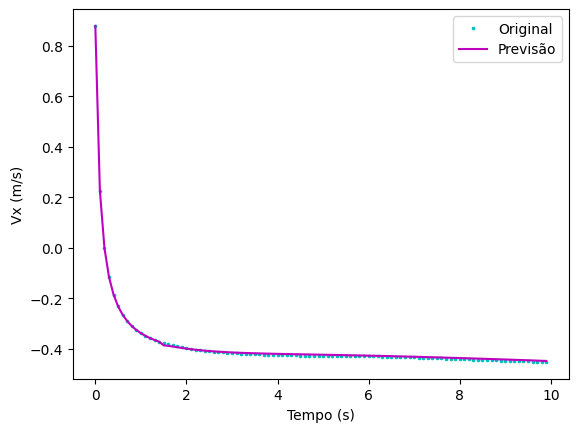

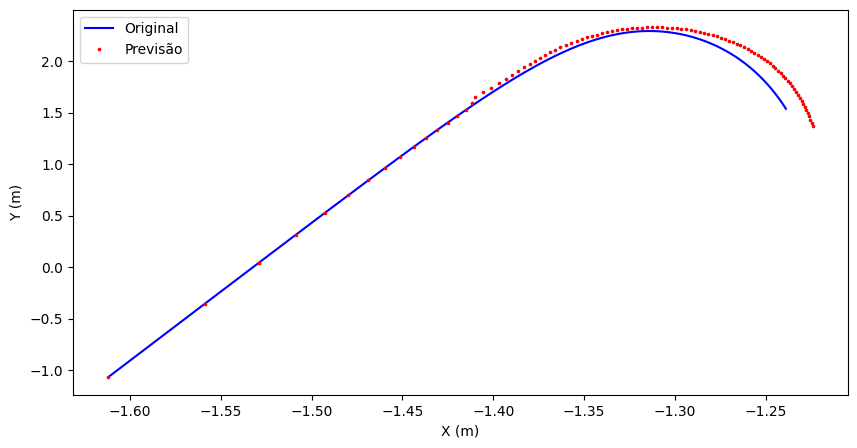

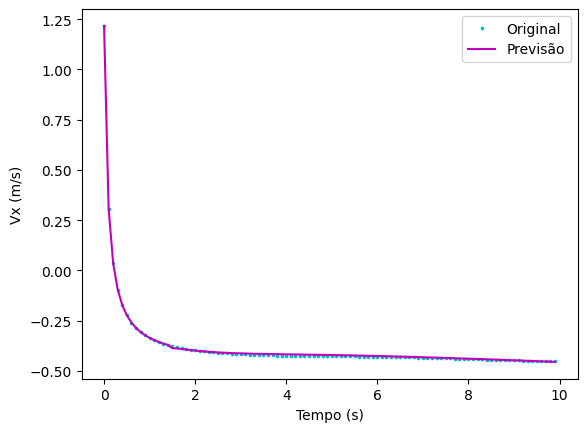

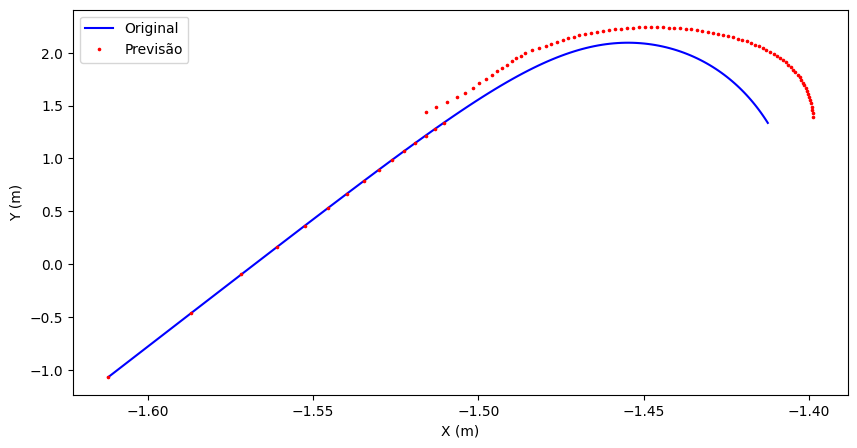

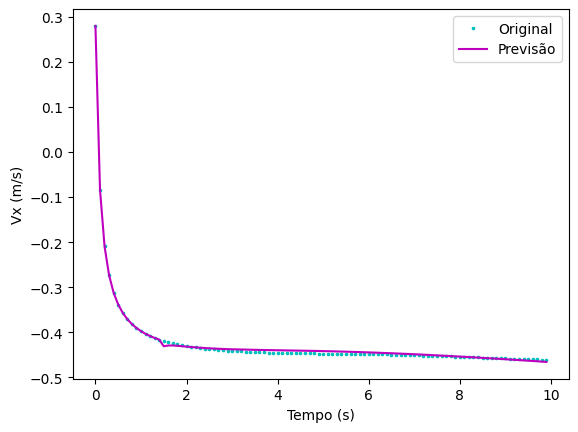

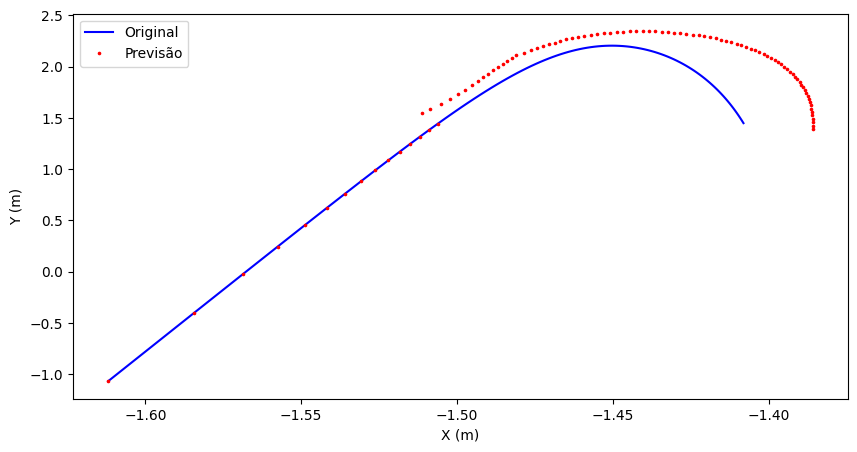

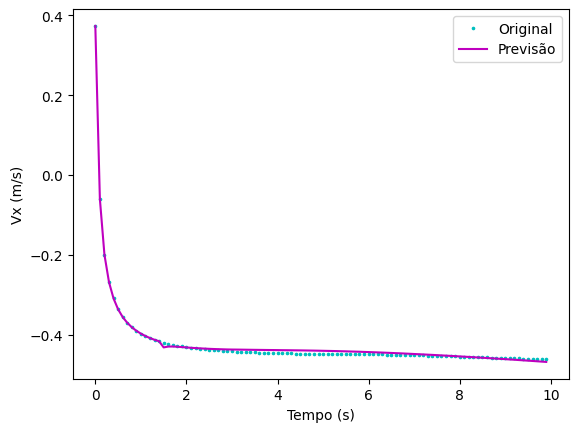

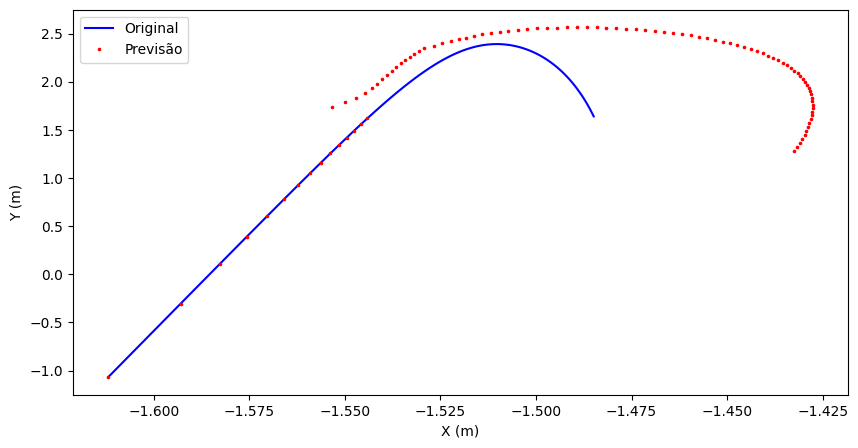

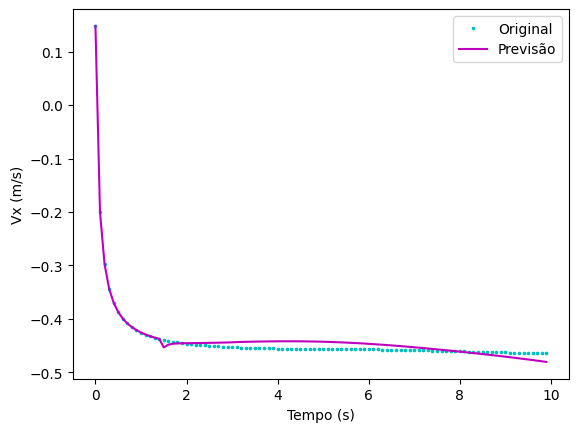

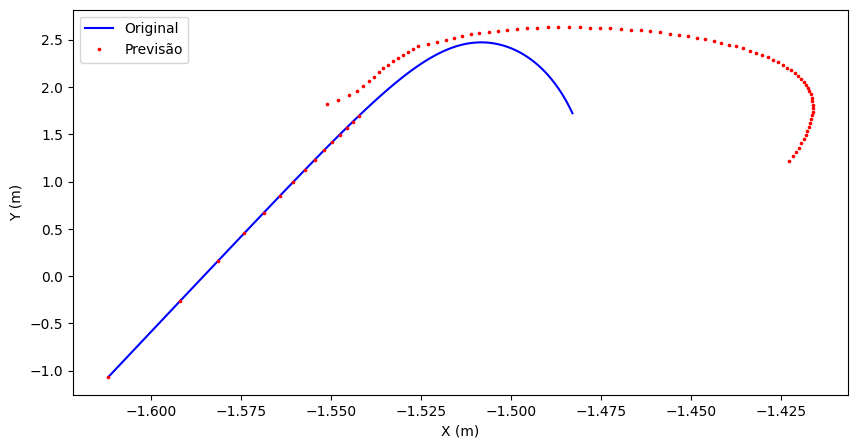

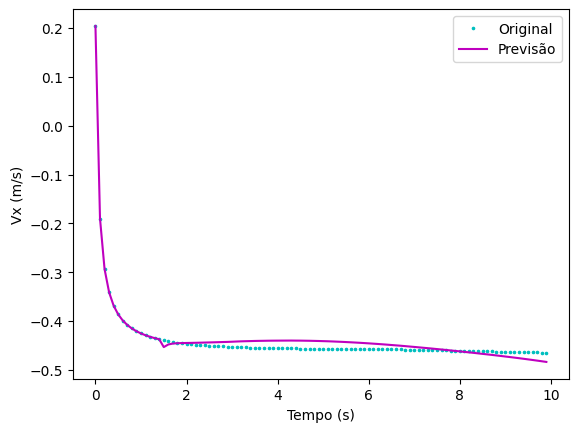

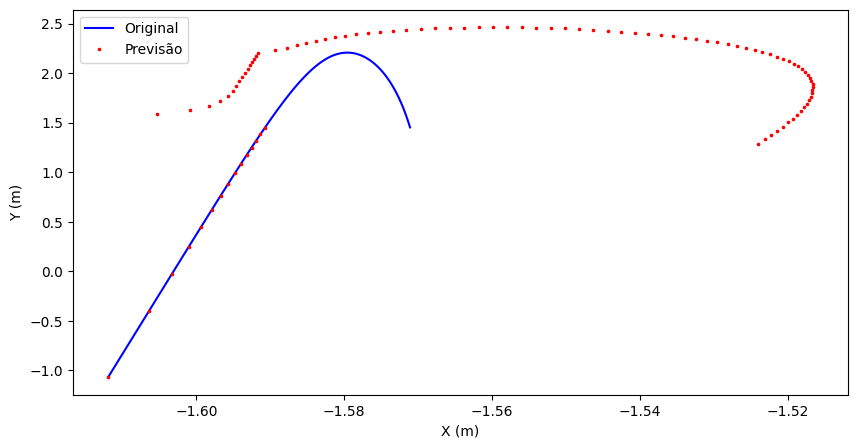

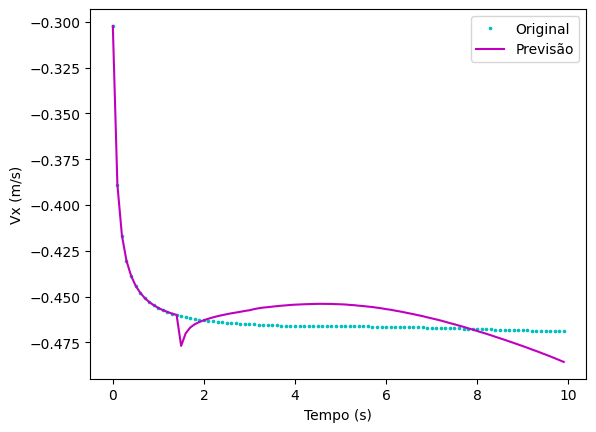

KeyboardInterrupt: 

In [69]:
angulos1 = np.linspace(5,10,5)
angulos2 = np.linspace(85.5,89.5,5)
velocidades1 = np.linspace(50,100,5)
velocidades2 = np.linspace(1000,1500,5)
angulos_teste = [angulos1,angulos2]
velocidades_teste = [velocidades1, velocidades2]
mse = 0
mae = 0
cont = 0
for angle in angulos2:
    for velocity in velocidades2:
        t_final = 10
        '''sol2 = np.stack(makepath(angle,velocity,t_final+0.1,0.1)[:4],axis=1)
        previsoes = ((sol2[:train_window,:]+0*np.random.normal(0,0.05 * np.ptp(sol2,axis=0),size=(train_window,4)))).tolist()#-inputs_mean)/inputs_std).tolist()
        #sol2 = (sol2-inputs_mean)/inputs_std
        for i in range(101-train_window+t_final*10-100):
            prev_temp = model_keras((np.array([previsoes[k][:] for k in range(i,train_window+i)]).reshape(-1,train_window,4)))
            previsoes.append(prev_temp.numpy().tolist()[0])
        previsoes = np.array(previsoes)'''
        X, Y, VX, VY, T  = makepath(angle, velocity, t_final+0.1, 0.1) 
        sol2 = np.stack((X, Y, np.sqrt(VX**2 ,VY**2)),axis=1)
        previsoes = ((sol2[:train_window,:]+0*np.random.normal(size=(train_window,3))-inputs_mean)/inputs_std).tolist()
        sol2 = (sol2-inputs_mean)/inputs_std
        previsoes = (sol2[:train_window,:]+0*np.random.normal(size=(train_window,3))).tolist()
        for i in range(101-train_window+t_final*10-100):
            prev_temp = model_keras((np.array([previsoes[k][:] for k in range(i,train_window+i)]).reshape(-1,train_window,3)),training=False)
            previsoes.append(prev_temp.numpy().tolist()[0])
        previsoes = np.array(previsoes)

        mse+=(tf.reduce_mean(tf.square(previsoes-sol2)))
        mae+=(tf.reduce_mean(tf.abs(previsoes-sol2)))
        cont+=1
        t_pontos = np.arange(0,t_final+0.1,0.1)
        plotar = np.random.randint(0,11)
        if plotar<=1:
            plt.figure(figsize=(10,5))
            x = sol2[:,0]
            y =  sol2[:,1]
            v_x = sol2[:,2]
            #v_y =  sol2[:,3]
            x_2 = previsoes[:,0]
            y_2 = previsoes[:,1]
            vx_2 = previsoes[:,2]
            #vy_2 = previsoes[:,3]
            plt.plot(x[m:n], y[m:n], 'b-', label="Original")
            plt.plot(x_2[m:n], y_2[m:n], 'ro', label="Previsão",markersize=1.6)
            plt.legend()
            plt.xlabel("X (m)")
            plt.ylabel("Y (m)")
            plt.show()

            plt.plot(t_pontos[m:n], v_x[m:n], 'co', label="Original",markersize=1.6)
            plt.plot(t_pontos[m:n], vx_2[m:n], 'm-', label="Previsão",markersize=0.4)
            plt.legend()
            plt.xlabel("Tempo (s)")
            plt.ylabel("Vx (m/s)")
            plt.show()

            ''' plt.plot(t_pontos[m:n], v_y[m:n], 'co', label="Original",markersize=1.6)
            plt.plot(t_pontos[m:n], vy_2[m:n], 'm-', label="Previsão",markersize=0.4)
            plt.legend()
            plt.xlabel("Tempo (s)")
            plt.ylabel("Vy (m/s)")
            plt.show()'''
print(mse/cont)
print(mae/cont)
        



A1, V1
tf.Tensor(9.419492247029146e-05, shape=(), dtype=float64)
tf.Tensor(0.005105998652613733, shape=(), dtype=float64)

A2, V1
tf.Tensor(0.00026263037160767424, shape=(), dtype=float64)
tf.Tensor(0.008951077640077531, shape=(), dtype=float64)

A1,V2
tf.Tensor(0.00022935536072032008, shape=(), dtype=float64)
tf.Tensor(0.008927641115422973, shape=(), dtype=float64)

A2,V2
f.Tensor(0.0007669445568704249, shape=(), dtype=float64)
tf.Tensor(0.015728456597145533, shape=(), dtype=float64)